# Neutral Atmosphere Lab

This lab will guide you through performing basic analysis and plotting of neutral atmosphere GNSS radio occultation (RO) data from CDAAC.

For this, we'll...

## Data selection

Let's first select the date we'll analyze. This will be done in the typical RO format of year.day_of_year. For example, 2023 May 01 is coded as '2023.121'. A day of year calendar, such as [this one hosted at NOAA ESRL](https://www.esrl.noaa.gov/gmd/grad/neubrew/Calendar.jsp?view=DOY&year=2023&col=4), can be helpful when working with this format. <a id='yrdoy_seed_cell'></a>

In [1]:
# USER INPUT: Date selection
data_yrdoy = '2023.060'

# USER INPUT: Random number generator seed; set to None for random
seed = 18239

The above date determines the data directories from which we will read occultation files. The below will use Python f-strings to fill the year.day_of_year variable `data_yrdoy` between curly brackets in the string declaration.

In [2]:
# Data directories for neutral atmosphere products
atmPrf_data_dir = f'../GNSS-data/cosmic2/atmPrf/{data_yrdoy}/'
wetPf2_data_dir = f'../GNSS-data/cosmic2/wetPf2/{data_yrdoy}/'

# Information
print(f'[INFO] Data directory for atmPrf : {atmPrf_data_dir}')
print(f'[INFO] Data directory for wetPf2 : {wetPf2_data_dir}')

[INFO] Data directory for atmPrf : ../GNSS-data/cosmic2/atmPrf/2023.060/
[INFO] Data directory for wetPf2 : ../GNSS-data/cosmic2/wetPf2/2023.060/


## Imports

In [3]:
# Libraries
import os
import requests
import tarfile
from datetime import datetime
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## Preparation

Note: this section may be skipped if the data are downloaded and extracted into the appropriate directories.

Using our examples from the previous days' labs, download the data files we'll use, if they don't already exist.

To start, we'll use Python functionality to create a data directory structure to hold our data and plots. TODO: Fill in more information about the structure.

In [4]:
# Create directories, if they don't already exist
os.makedirs(atmPrf_data_dir,exist_ok=True)
os.makedirs(wetPf2_data_dir,exist_ok=True)

Now check if the tar files exist. Download them if not. Check if the tar files have been untarred. Untar them if not. The below will use Python f-strings to fill the file name and server path variables using the date variables.

In [5]:
# Get the year and day-of-year separately
data_year, data_doy = data_yrdoy.split('.')

# Tar file names and paths
atmPrf_tar_fname = f'atmPrf_nrt_{data_year}_{data_doy}.tar.gz'
wetPf2_tar_fname = f'wetPf2_nrt_{data_year}_{data_doy}.tar.gz'
atmPrf_tar_path = f'../GNSS-data/cosmic2/atmPrf/{atmPrf_tar_fname}'
wetPf2_tar_path = f'../GNSS-data/cosmic2/wetPf2/{wetPf2_tar_fname}'

# Server path
cdaac_url = f'https://data.cosmic.ucar.edu/gnss-ro/cosmic2/nrt/level2/{data_year}/{data_doy}/'
atmPrf_tar_url = f'{cdaac_url}{atmPrf_tar_fname}'
wetPf2_tar_url = f'{cdaac_url}{wetPf2_tar_fname}'

# atmPrf tar file is downloaded?
if (not os.path.isfile(atmPrf_tar_path)):
    response = requests.get(atmPrf_tar_url, stream=True)
    if response.status_code == 200:
        with open(atmPrf_tar_path, 'wb') as fileid:
            fileid.write(response.raw.read())

# atmPrf is untarred?
if (len(os.listdir(atmPrf_data_dir)) == 0):
    with tarfile.open(atmPrf_tar_path) as fileid:
        fileid.extractall(atmPrf_data_dir)

# wetPf2 tar file is downloaded?
if (not os.path.isfile(wetPf2_tar_path)):
    response = requests.get(wetPf2_tar_url, stream=True)
    if response.status_code == 200:
        with open(wetPf2_tar_path, 'wb') as fileid:
            fileid.write(response.raw.read())

# wetPf2 is untarred?
if (len(os.listdir(wetPf2_data_dir)) == 0):
    with tarfile.open(wetPf2_tar_path) as fileid:
        fileid.extractall(wetPf2_data_dir)

## Analysis of a single occultation

This section will show how to generate simple plots of a single occultation. We will use these plots to further explore the contents of both of the primary neutral atmospheric products: atmPrf and wetPf2.

As a reminder, atmPrf contains the high-resolution occultation data, including bending angle and refractivity, and atmospheric fields calculated under the assumption of no water vapor. The wetPf2 product contains atmospheric fields retrieved through use of a one-dimensional variational analysis process. The below example analysis will illustrate the different resolutions and contents of both products.

First we will select a random occultation from the data directory, ensuring that it has been labelled "good" by the CDAAC quality controls. We will perform this check using both the atmPrf and wetPf2 products.

We will first count the number of profiles.

In [6]:
# Get the occultation file names and counts in our directories
atmPrf_fnames = os.listdir(atmPrf_data_dir)
wetPf2_fnames = os.listdir(wetPf2_data_dir)
n_atmPrf = len(atmPrf_fnames)
n_wetPf2 = len(wetPf2_fnames)

# Information
print(f'[INFO] Number of atmPrf files : {n_atmPrf}')
print(f'[INFO] Number of wetPf2 files : {n_wetPf2}')

[INFO] Number of atmPrf files : 5687
[INFO] Number of wetPf2 files : 5687


Now initialize the random number generator. For demonstration purposes, the random number generator will be initialized such that it always selects the same profile.

Select the random (or "random") profile index.

In [7]:
# Set up the random number generator
# seed is set in the user inputs
rng = np.random.default_rng(seed)

# Select a random integer up to the minimum of the two counts
max_prf_count = np.min([n_atmPrf,n_wetPf2])
prf_idx = rng.integers(low=0, \
                       high=max_prf_count,
                       size=1
                      )[0]

# Get the profile ID using the atmPrf data set
atmPrf_fname_short_now = atmPrf_fnames[prf_idx]
wetPf2_fname_short_now = atmPrf_fname_short_now.replace('atmPrf','wetPf2')
prf_id_now = atmPrf_fname_short_now.split('_')[1]

# Get the file names
atmPrf_fname_now = f'{atmPrf_data_dir}{atmPrf_fname_short_now}'
wetPf2_fname_now = f'{wetPf2_data_dir}{wetPf2_fname_short_now}'
atmPrf_fname_short_now = atmPrf_fname_now.split('/')[-1]
wetPf2_fname_short_now = wetPf2_fname_now.split('/')[-1]

# Information
print(f'[INFO] Selected index                   : {prf_idx}')
print(f'[INFO] Selected atmPrf file name        : {atmPrf_fname_short_now}')
print(f'[INFO] Selected wetPf2 file name        : {wetPf2_fname_short_now}')
print(f'[INFO] Selected atmPrf file name (full) : {atmPrf_fname_now}')
print(f'[INFO] Selected wetPf2 file name (full) : {wetPf2_fname_now}')
print(f'[INFO] Selected profile ID              : {prf_id_now}')

[INFO] Selected index                   : 1816
[INFO] Selected atmPrf file name        : atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected wetPf2 file name        : wetPf2_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected atmPrf file name (full) : ../GNSS-data/cosmic2/atmPrf/2023.060/atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected wetPf2 file name (full) : ../GNSS-data/cosmic2/wetPf2/2023.060/wetPf2_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected profile ID              : C2E1.2023.060.02.02.G29


Read the files into memory. Check if they are flagged as "bad" or not. Profiles are flagged as "bad" if the global attribute "bad" is 1.

In [8]:
# Use netCDF4 to read the files
atmPrf_ncid_now = Dataset(atmPrf_fname_now,'r')
wetPf2_ncid_now = Dataset(wetPf2_fname_now,'r')

# Read bad flags from both files
atmPrf_bad_flag = int(atmPrf_ncid_now.bad)
wetPf2_bad_flag = int(wetPf2_ncid_now.bad)
atmPrf_bad_or_good = 'bad' if atmPrf_bad_flag else 'good'
wetPf2_bad_or_good = 'bad' if wetPf2_bad_flag else 'good'

# Information
print(f'[INFO] atmPrf file bad flag is "{atmPrf_bad_flag}"; the file is {atmPrf_bad_or_good.upper()}.')
print(f'[INFO] wetPf2 file bad flag is "{wetPf2_bad_flag}"; the file is {wetPf2_bad_or_good.upper()}.')

[INFO] atmPrf file bad flag is "0"; the file is GOOD.
[INFO] wetPf2 file bad flag is "0"; the file is GOOD.


For the demonstration, the random number generator has been seeded such that the occultation we select is "good" in both files. If the random number generator was not seeded in this way -- say by using the commented command for `rng` above -- then the below will iteratively check the files until a "good" occultation is selected.

In [9]:
"""
Loop through files until a good atmPrf and wetPf2 pair are found
"""
n_rnd_idx_now = 1
while ( (atmPrf_bad_flag | wetPf2_bad_flag) 
       & (n_rnd_idx_now < max_prf_count) ):
    # Get a new random index
    prf_idx = rng.integers(low=0, \
                           high=max_prf_count,
                           size=1
                          )[0]
    # Get the profile ID using the atmPrf data set
    atmPrf_fname_short_now = atmPrf_fnames[prf_idx]
    wetPf2_fname_short_now = atmPrf_fname_short_now.replace('atmPrf','wetPf2')
    prf_id_now = atmPrf_fname_short_now.split('_')[1]
    
    # Get the file names
    atmPrf_fname_now = f'{atmPrf_data_dir}{atmPrf_fname_short_now}'
    wetPf2_fname_now = f'{wetPf2_data_dir}{wetPf2_fname_short_now}'
    atmPrf_fname_short_now = atmPrf_fname_now.split('/')[-1]
    wetPf2_fname_short_now = wetPf2_fname_now.split('/')[-1]
    
    # Close older files
    atmPrf_ncid_now.close()
    wetPf2_ncid_now.close()
    
    # Use netCDF4 to read the new files
    atmPrf_ncid_now = Dataset(atmPrf_fname_now,'r')
    wetPf2_ncid_now = Dataset(wetPf2_fname_now,'r')
    
    # Read bad flags from both files
    atmPrf_bad_flag = int(atmPrf_ncid_now.bad)
    wetPf2_bad_flag = int(wetPf2_ncid_now.bad)
    atmPrf_bad_or_good = 'bad' if atmPrf_bad_flag else 'good'
    wetPf2_bad_or_good = 'bad' if wetPf2_bad_flag else 'good'

    # Iterate
    n_rnd_idx_now += 1

# Information
print(f'[INFO] Selected index                   : {prf_idx}')
print(f'[INFO] Selected atmPrf file name        : {atmPrf_fname_short_now}')
print(f'[INFO] Selected wetPf2 file name        : {wetPf2_fname_short_now}')
print(f'[INFO] Selected atmPrf file name (full) : {atmPrf_fname_now}')
print(f'[INFO] Selected wetPf2 file name (full) : {wetPf2_fname_now}')
print(f'[INFO] Selected profile ID              : {prf_id_now}')
print(f'[INFO] atmPrf file bad flag is "{atmPrf_bad_flag}"; the file is {atmPrf_bad_or_good.upper()}.')
print(f'[INFO] wetPf2 file bad flag is "{wetPf2_bad_flag}"; the file is {wetPf2_bad_or_good.upper()}.')

[INFO] Selected index                   : 1816
[INFO] Selected atmPrf file name        : atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected wetPf2 file name        : wetPf2_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected atmPrf file name (full) : ../GNSS-data/cosmic2/atmPrf/2023.060/atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected wetPf2 file name (full) : ../GNSS-data/cosmic2/wetPf2/2023.060/wetPf2_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO] Selected profile ID              : C2E1.2023.060.02.02.G29
[INFO] atmPrf file bad flag is "0"; the file is GOOD.
[INFO] wetPf2 file bad flag is "0"; the file is GOOD.


### Location of profile

For geolocation, we can use the nominal latitude and longitude of the occultation contained in the global attribues `lat` and `lon`, respectively. If full profiles of latitude and longitude are required, note that the variables `Lat` and `Lon` in atmPrf and `lat` and `lon` in wetPf2 are given at all levels.

Let's locate the selected profile using the nominal latitude and longitude, but show the full latitude and longitude variables on a map.

In [10]:
# Extract the nominal latitude and longitude
nom_lat = atmPrf_ncid_now.lat
nom_lon = atmPrf_ncid_now.lon
full_lat = atmPrf_ncid_now.variables['Lat'][:]
full_lon = atmPrf_ncid_now.variables['Lon'][:]

# Information
print(f'Nominal location of profile for {atmPrf_fname_short_now}')
print(f'    Latitude  : {nom_lat:6.2f}')
print(f'    Longitude : {nom_lon:6.2f}')

Nominal location of profile for atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
    Latitude  :  27.49
    Longitude : -47.16


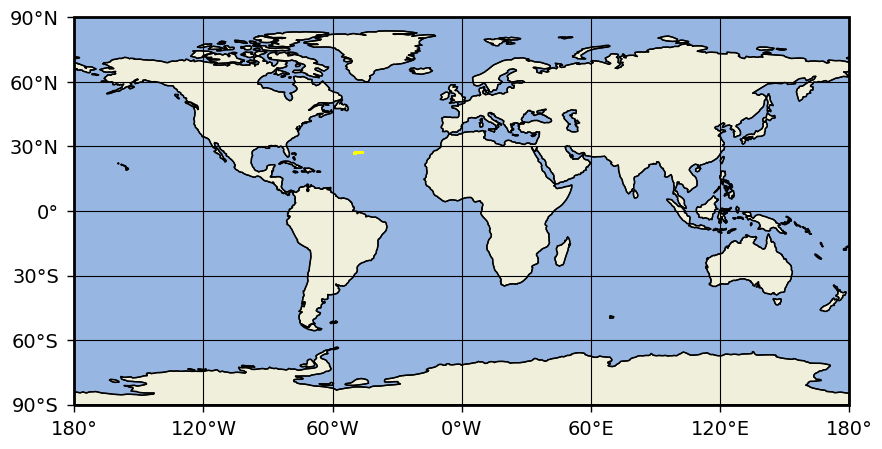

In [11]:
"""
Map the profile location
"""
# Generate the figure and axis objects with a map projection
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
axs.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())
# Add coastlines
axs.coastlines()
# Fill in land and water with colors
axs.add_feature(cfeature.OCEAN, zorder=0)
axs.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
# Add grids and labels
axs.gridlines(color='black')
axs.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axs.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.yaxis.set_major_formatter(lat_formatter)
# Add scatter values
av1 = axs.scatter(full_lon,full_lat,s=1,color='yellow',transform=ccrs.PlateCarree())
# Show the plot
plt.show()

### atmPrf

The atmPrf data set contains high-resolution profiles of neutral atmospheric variables which **do not** explicitly consider moisture. This includes bending angle, refractivity, "dry pressure," and "dry temperature", as well as positioning variables such as mean sea-level height, impact height, latitude, and longitude. Dry pressure and temperature are derived from refractivity assuming the atmosphere has no water vapor.

Let's investigate some of the variables of our selected atmPrf profile through plots of the fields.

Firstly, we'll extract the data into numpy arrays, and find out how many levels are in this profile.

In [12]:
# Extract the data from the netCDF
bending_angle = atmPrf_ncid_now.variables['Bend_ang'][:] * 1.E6 # Convert to units [microradians]
refractivity = atmPrf_ncid_now.variables['Ref'][:] # Units [N-units]
mean_sea_level_height_atmPrf = atmPrf_ncid_now.variables['MSL_alt'][:] # Units [km]

# Basic analysis of variable size
n_levs_atmPrf = mean_sea_level_height_atmPrf.size

# Information
print(f'[INFO] Number of levels in {atmPrf_fname_short_now} : {n_levs_atmPrf}')

[INFO] Number of levels in atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc : 3892


Next, generate plots of bending angle and refractivity versus mean sea-level height.

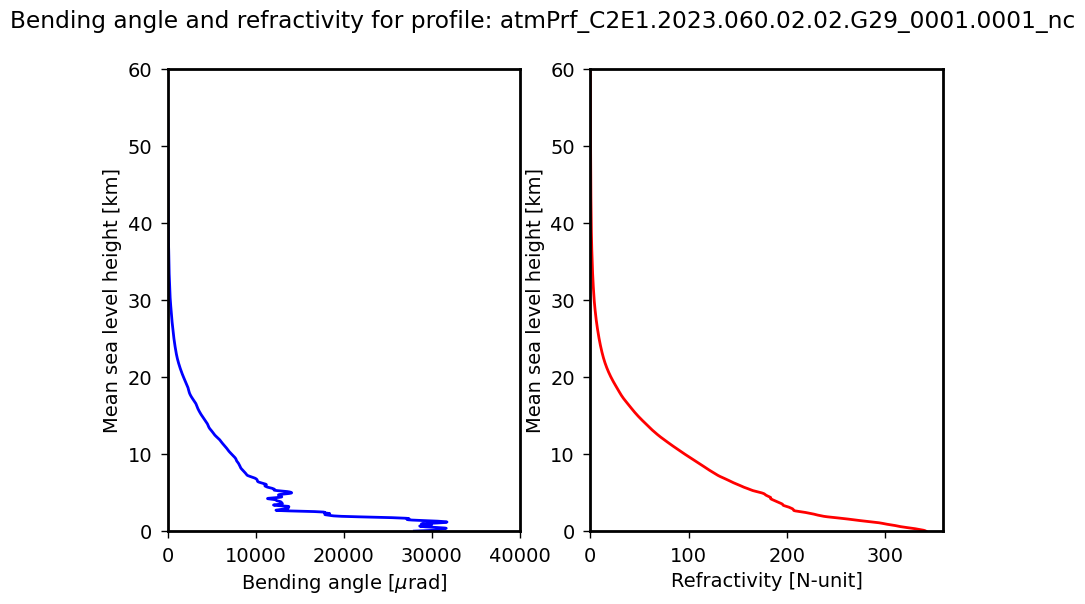

In [13]:
"""
Plot bending angle and refractivity versus mean sea-level height
"""
# Create the figure object with two columns and one row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# Add the data to each subplot contained in 'axs'
axs[0].plot(bending_angle,mean_sea_level_height_atmPrf,color='b')
axs[1].plot(refractivity,mean_sea_level_height_atmPrf,color='r')
# Set the axis labels
axs[0].set_xlabel('Bending angle [$\mu$rad]')
axs[1].set_xlabel('Refractivity [N-unit]')
axs[0].set_ylabel('Mean sea level height [km]')
axs[1].set_ylabel('Mean sea level height [km]')
# Set axis limits (None means unbounded; Matplotlib will decide)
axs[0].set_xlim(0,40000)
axs[1].set_xlim(0,None)
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,60)
# Set the title
fig.suptitle(f'Bending angle and refractivity for profile: {atmPrf_fname_short_now}')
# Generate the plot
plt.show()

Bending angle and refractivity generally decrease exponentially with height, so few details are visible above 30 km. To see more detail at all levels, we can redo the above plots with a logarithmic x-axis. Note that we will have to adjust our lower axis limits to be non-zero.

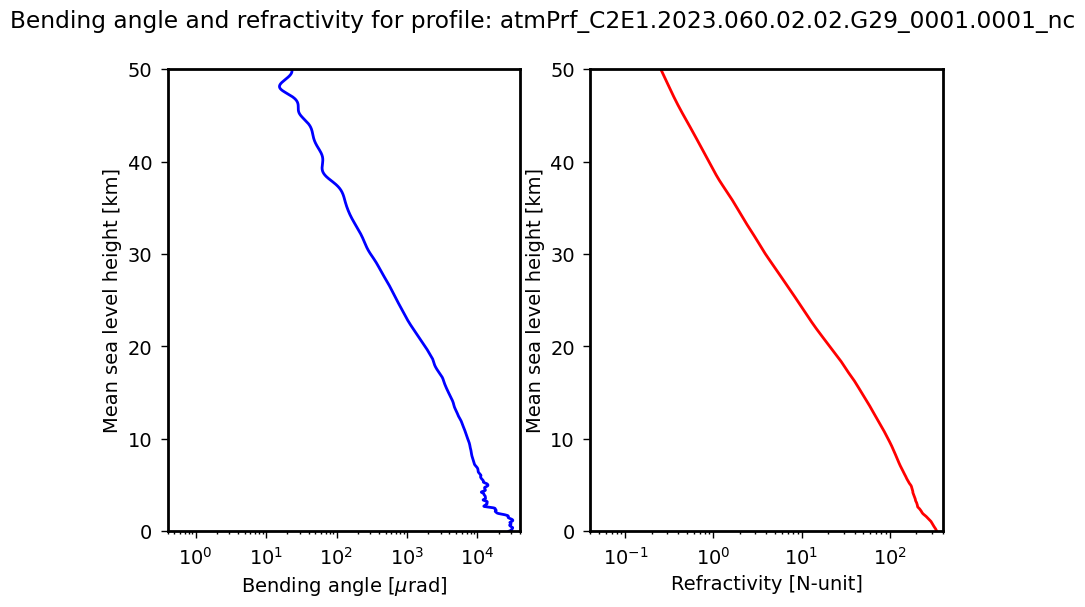

In [14]:
"""
Plot bending angle and refractivity versus mean sea-level height,
now on a logarithmic scale.
"""
# Create the figure object with two columns and one row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# Add the data to each subplot contained in 'axs'
axs[0].plot(bending_angle,mean_sea_level_height_atmPrf,color='b')
axs[1].plot(refractivity,mean_sea_level_height_atmPrf,color='r')
# Set the axis labels
axs[0].set_xlabel('Bending angle [$\mu$rad]')
axs[1].set_xlabel('Refractivity [N-unit]')
axs[0].set_ylabel('Mean sea level height [km]')
axs[1].set_ylabel('Mean sea level height [km]')
# Set axis limits (None means unbounded; Matplotlib will decide)
axs[0].set_xlim(0.4,40000)
axs[1].set_xlim(0.04,400)
axs[0].set_ylim(0,50)
axs[1].set_ylim(0,50)
# Set the x-axis to be logarithmic
axs[0].set_xscale('log')
axs[1].set_xscale('log')
# Set the title
fig.suptitle(f'Bending angle and refractivity for profile: {atmPrf_fname_short_now}')
# Generate the plot
plt.show()

Now let's further investigate the levels of the data in atmPrf. These data are not given on a uniform grid. The vertical levels between profiles are not the same, and the spacing between vertical levels within one profile is not the same.

To see this latter characteristic, let's calculate the vertical spacing (in mean se-level height) of all levels and generate a simple histogram.

In [15]:
"""
Statistics of the vertical spacing
"""
# Calculate the magnitude of the spacing in [m]
dz_levs = np.abs(mean_sea_level_height_atmPrf[1:]
                 -mean_sea_level_height_atmPrf[:-1]) * 1.E3
# Calculate the statistics of the spacing
dz_levs_mean = np.mean(dz_levs)
dz_levs_stddev = np.std(dz_levs)

# Information
print(f'[INFO] Vertical spacing in [m] for {atmPrf_fname_short_now}')
print(f'[INFO]     Mean     : {dz_levs_mean:7.2f}')
print(f'[INFO]     Std. Dev : {dz_levs_stddev:7.2f}')

[INFO] Vertical spacing in [m] for atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc
[INFO]     Mean     :   20.56
[INFO]     Std. Dev :    1.65


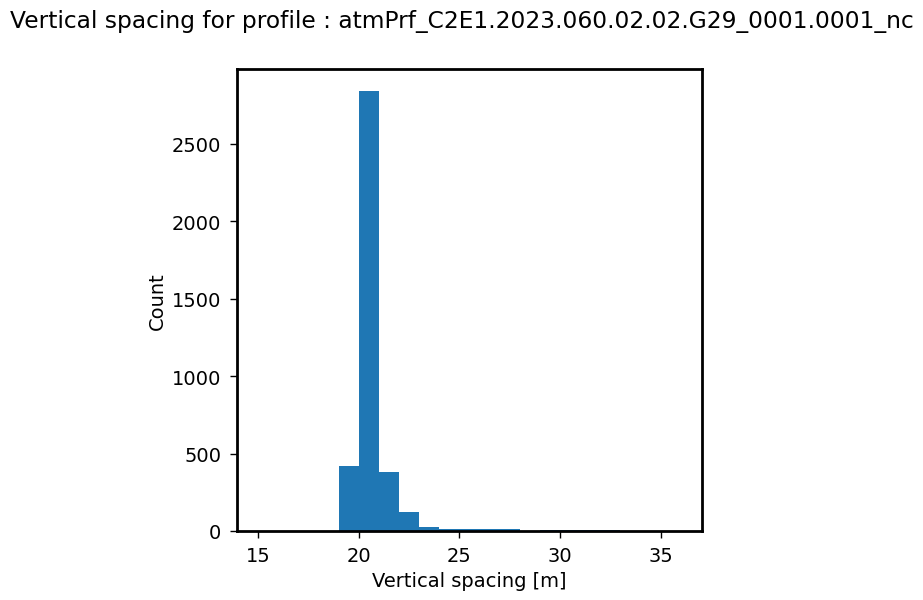

In [16]:
"""
Generate a histogram
Set the bins to span 15-35
"""
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.hist(dz_levs, bins=np.arange(15,37,1.0))
axs.set_xlabel('Vertical spacing [m]')
axs.set_ylabel('Count')
fig.suptitle(f'Vertical spacing for profile : {atmPrf_fname_short_now}')
plt.show()

### wetPf2

The wetPf2 data set contains uniformly spaced profiles of neutral atmospheric variables which **do** explicitly consider moisture. This includes pressure, temperature, and specific humidity, as well as the same positioning variables as in atmPrf. Geopotential height values are also provided.

As before, we'll extract the data into numpy arrays, and find out how many levels are in this profile. Then we'll generate some plots of temperature and specific humidity. Since nearly all moisture exists below approximately 10 km, we will limit the specific humidity plot accordingly.

Note that the spacing of wetPf2 files is 50 m up to 20 km, and then 100 m above 20 km.

In [17]:
# Extract the data from the netCDF
temperature = wetPf2_ncid_now.variables['Temp'][:] # Units [deg C]
specific_humidity = wetPf2_ncid_now.variables['sph'][:] # Units [g/kg]
relative_humidity = wetPf2_ncid_now.variables['rh'][:] # Units [%]
mean_sea_level_height_wetPf2 = wetPf2_ncid_now.variables['MSL_alt'][:] # Units [km]

# Basic analysis of variable size
n_levs_wetPf2 = mean_sea_level_height_wetPf2.size

# Find the index closest to 20 km mean sea-level height level
idx_20km_wetPf2 = np.nanargmin(np.abs(mean_sea_level_height_wetPf2-20.0))

# Calculate the magnitude of the spacing in [m]
dz_levs_wetPf2_lower = np.abs(mean_sea_level_height_wetPf2[:idx_20km_wetPf2][1:]
                              -mean_sea_level_height_wetPf2[:idx_20km_wetPf2][:-1]) * 1.E3
dz_levs_wetPf2_upper = np.abs(mean_sea_level_height_wetPf2[idx_20km_wetPf2:][1:]
                              -mean_sea_level_height_wetPf2[idx_20km_wetPf2:][:-1]) * 1.E3
# Calculate the statistics of the spacing
dz_levs_mean_wetPf2_lower = np.mean(dz_levs_wetPf2_lower)
dz_levs_stddev_wetPf2_lower = np.std(dz_levs_wetPf2_lower)
dz_levs_mean_wetPf2_upper = np.mean(dz_levs_wetPf2_upper)
dz_levs_stddev_wetPf2_upper = np.std(dz_levs_wetPf2_upper)

# Information
print(f'[INFO] Number of levels in {wetPf2_fname_short_now} : {n_levs_wetPf2}')
print(f'[INFO] Vertical spacing in [m] for {atmPrf_fname_short_now} below 20 km')
print(f'[INFO]     Mean     : {dz_levs_mean_wetPf2_lower:7.2f}')
print(f'[INFO]     Std. Dev : {dz_levs_stddev_wetPf2_lower:7.2f}')
print(f'[INFO] Vertical spacing in [m] for {atmPrf_fname_short_now} above 20 km')
print(f'[INFO]     Mean     : {dz_levs_mean_wetPf2_upper:7.2f}')
print(f'[INFO]     Std. Dev : {dz_levs_stddev_wetPf2_upper:7.2f}')

[INFO] Number of levels in wetPf2_C2E1.2023.060.02.02.G29_0001.0001_nc : 801
[INFO] Vertical spacing in [m] for atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc below 20 km
[INFO]     Mean     :   50.00
[INFO]     Std. Dev :    0.00
[INFO] Vertical spacing in [m] for atmPrf_C2E1.2023.060.02.02.G29_0001.0001_nc above 20 km
[INFO]     Mean     :  100.00
[INFO]     Std. Dev :    0.00


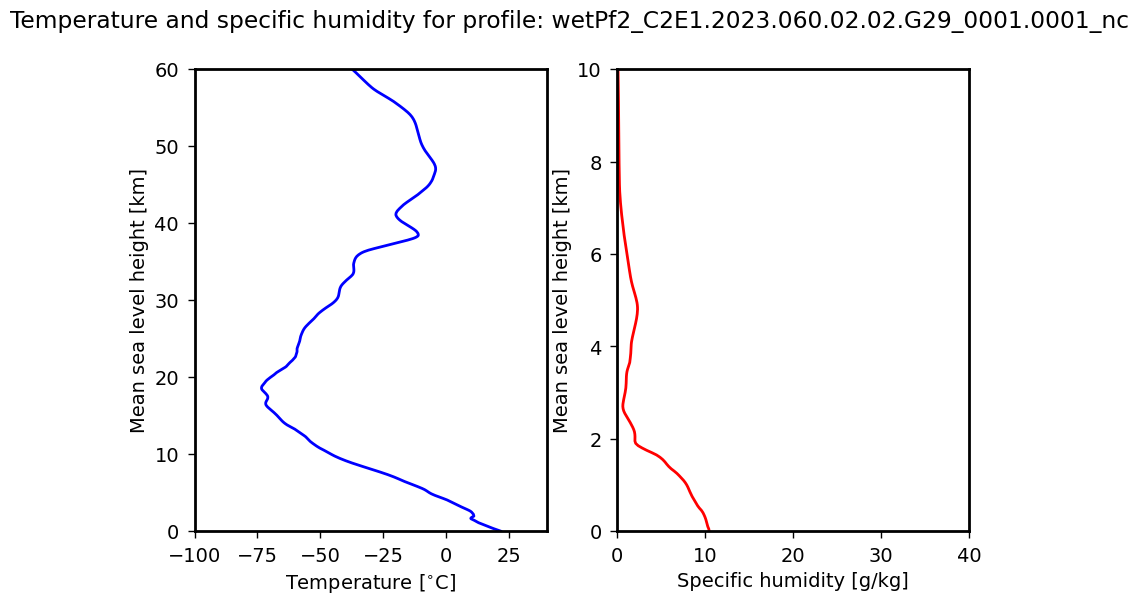

In [18]:
"""
Plot temperature and specific humidity versus mean sea-level height
"""
# Create the figure object with two columns and one row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# Add the data to each subplot contained in 'axs'
axs[0].plot(temperature,mean_sea_level_height_wetPf2,color='b')
axs[1].plot(specific_humidity,mean_sea_level_height_wetPf2,color='r')
# Set the axis labels
axs[0].set_xlabel('Temperature [$^{\circ}$C]')
axs[1].set_xlabel('Specific humidity [g/kg]')
axs[0].set_ylabel('Mean sea level height [km]')
axs[1].set_ylabel('Mean sea level height [km]')
# Set axis limits (None means unbounded; Matplotlib will decide)
axs[0].set_xlim(-100,40)
axs[1].set_xlim(0,40)
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,10)
# Set the title
fig.suptitle(f'Temperature and specific humidity for profile: {wetPf2_fname_short_now}')
# Generate the plot
plt.show()

## Analysis of multiple occultations

Here we go through a brief exercise in reading multiple wetPf2 files and analyzing many occultations at once.

All wetPf2 files share a common grid. Given the spacing discussed in the [wetPf2](#wetPf2) section, a profile that spans 0-60 km would have 800 levels. However, not all have data that span the range 0-60 km, and only levels with data are saved into wetPf2 files. Thus, a profile that ends at 400 m would only have 793 levels. We will account for this through numPy indexing shown below.

Here we will read in 100 profiles and generate statistics at a specified level, say, 5 km.

In [19]:
"""
Loop over randomly selected profiles, retaining data from profiles
flagged as 'good' until 100 have been read.
"""
# Initialize arrays
n_levs_wetPf2 = 801 # This is the max levels that a wetPf2 can have
mult_prf_ids = np.full(100,'')
mult_temperature = np.full((100,n_levs_wetPf2),np.nan)
mult_specific_humidity = np.full((100,n_levs_wetPf2),np.nan)

# Randomly sort indices for selecting the profiles
prf_idx_all = rng.choice(max_prf_count,
                         size=max_prf_count,
                         replace=False,
                        )

# Loop until 100 are read
n_prf_read = 0
n_rnd_idx_now = 0
while ( (n_prf_read < 100) & (n_rnd_idx_now < max_prf_count) ):
    prf_idx_now = prf_idx_all[n_rnd_idx_now]
    
    # Get the file name
    wetPf2_fname_short_now = wetPf2_fnames[prf_idx_now]
    wetPf2_fname_now = f'{wetPf2_data_dir}{wetPf2_fname_short_now}'
    prf_id_now = wetPf2_fname_short_now.split('_')[1]
    
    # Close older file, if needed
    try:
        wetPf2_ncid_now.close()
    except:
        pass
    
    # Use netCDF4 to read the new file
    wetPf2_ncid_now = Dataset(wetPf2_fname_now,'r')
    
    # Read bad flag. If good, store data.
    wetPf2_bad_flag = int(wetPf2_ncid_now.bad)
    if wetPf2_bad_flag:
        pass
    else:
        mult_prf_ids[n_prf_read] = prf_id_now
        # Count the levels in this file 
        # and align the profiles using indexing
        mean_sea_level_height_wetPf2_now = wetPf2_ncid_now.variables['MSL_alt'][:]
        n_levs_wetPf2_now = mean_sea_level_height_wetPf2_now.size
        mult_temperature[n_prf_read,n_levs_wetPf2-n_levs_wetPf2_now:] \
            = wetPf2_ncid_now.variables['Temp'][:]
        mult_specific_humidity[n_prf_read,n_levs_wetPf2-n_levs_wetPf2_now:] \
            = wetPf2_ncid_now.variables['sph'][:]
        n_prf_read += 1

    # Iterate
    n_rnd_idx_now += 1

print(f'[INFO] Number of iterations to find 100 : {n_rnd_idx_now}')

[INFO] Number of iterations to find 100 : 113


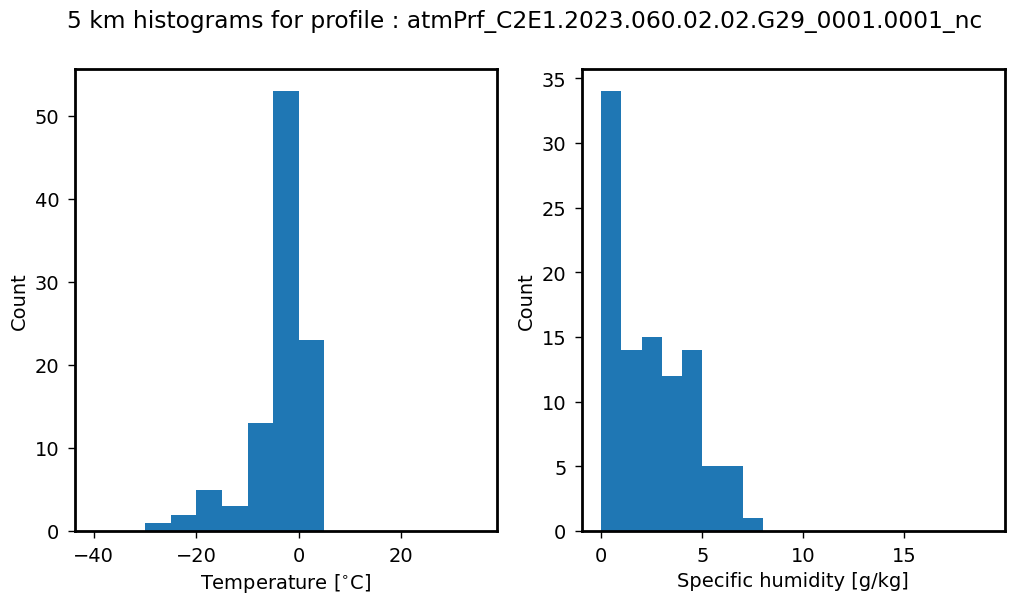

[INFO] 5 km statistics for multiple wetPf2 files
[INFO] Temperature
[INFO]     Mean     :   -3.54
[INFO]     Std. Dev :    5.95
[INFO] Specific humidity
[INFO]     Mean     :    2.44
[INFO]     Std. Dev :    1.95


In [20]:
"""
Generate a histogram of values at 5 km,
and calculate statistics
"""
# Get the index for the 5 km level
idx_05km_wetPf2 = np.nanargmin(np.abs(mean_sea_level_height_wetPf2-5.0))

# Calculate statistics; note we use NaN-masking functions
# as not all profiles reach the surface
mult_temperature_mean = np.nanmean(mult_temperature[:,idx_05km_wetPf2])
mult_temperature_stddev = np.nanstd(mult_temperature[:,idx_05km_wetPf2])
mult_specific_humidity_mean = np.nanmean(mult_specific_humidity[:,idx_05km_wetPf2])
mult_specific_humidity_stddev = np.nanstd(mult_specific_humidity[:,idx_05km_wetPf2])

# Make the histrogram plot
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].hist(mult_temperature[:,idx_05km_wetPf2], bins=np.arange(-40,40,5))
axs[1].hist(mult_specific_humidity[:,idx_05km_wetPf2], bins=np.arange(0,20,1))
axs[0].set_xlabel('Temperature [$^{\circ}$C]')
axs[0].set_ylabel('Count')
axs[1].set_xlabel('Specific humidity [g/kg]')
axs[1].set_ylabel('Count')
fig.suptitle(f'5 km histograms for profile : {atmPrf_fname_short_now}')
plt.show()

# Information
print(f'[INFO] 5 km statistics for multiple wetPf2 files')
print(f'[INFO] Temperature')
print(f'[INFO]     Mean     : {mult_temperature_mean:7.2f}')
print(f'[INFO]     Std. Dev : {mult_temperature_stddev:7.2f}')
print(f'[INFO] Specific humidity')
print(f'[INFO]     Mean     : {mult_specific_humidity_mean:7.2f}')
print(f'[INFO]     Std. Dev : {mult_specific_humidity_stddev:7.2f}')

## Exercises

Here are some exercises you can think about or do to dive a little deeper into analyzing the neutral atmosphere data.

1. Change the seed from [the first cell](#yrdoy_seed_cell) to a new integer or to None (for a random seed). Run the cells in the section [Analysis of a single occultation](#Analysis-of-a-single-occultation) to investigate this profile. Where is the new profile located? What is the penetration depth (lowest point in the occultation) of the profile? What is the new environment of the occultation: dry or humid, warm or cool? Has the tropopause height changed?

2. Generate a line plot of the mean temperature of the 100 profiles that were read in the section [Analysis of multiple occultations](#Analysis-of-multiple-occultations). Do the same for standard deviation. Calculate the mean penetration depth of the profiles.

3. Redo the [Analysis of multiple occultations](#Analysis-of-multiple-occultations) section, but require the profiles to reach down to 500 m mean sea level height or lower.

4. Since the atmPrf grid is non-uniform, how would you go about analyzing the mean refractivity and bending angles as a function of mean sea level height for a set of atmPrf profiles?